In [72]:
# !pip install gymnasium
# !pip install matplotlib
# !pip install gym
# !pip install pygame

In [73]:
import gymnasium as gym
import matplotlib.pyplot as plt
import re

def remove_color(text):
    ansi_escape = re.compile(r'\x1B(?:[@-Z\\-_]|\[[0-?]*[ -/]*[@-~])')
    return ansi_escape.sub('', text)


# launch adventure environment with human rendering
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="ansi")
# todo make this random maps
# render_mode="rgb_array"
env.reset()

env_map = remove_color(env.render())

number_of_actions = env.action_space.n

In [74]:
# def extract_ansi_positions(input_string):
#     ansi_pattern = r'\033\[[0-9;]*m'
#     ansi_matches = re.finditer(ansi_pattern, input_string)
    
#     positions = []
#     for match in ansi_matches:
#         start = match.start()
#         end = match.end()
#         positions.append((start, end))
    
#     return positions

# env_map = env.render()
# positions = extract_ansi_positions(env_map)
# for position in positions:
#     print(f"Escaped string starts at position {position[0]} and ends at position {position[1]}")

# def get_position_based_on_color(env_map):

#     # get size of map
#     easy_map = env_map.split("\n")
#     easy_map = list(map(lambda x: list(x), easy_map))

#     print(easy_map)
    
#     size = len(map)

#     # get position of player

def extract_player_position(input_string):

    lines = input_string.split('\n')
    # remove empty array elements

    # remove empty lines
    lines = list(filter(lambda x: x != '', lines))

    # remove all lines with parenthesis
    lines = list(filter(lambda x: '(' not in x, lines))


    # for i in range(len(lines)):
    #     if lines[i] != '' and lines[i] is not None:
    #         lines_new.append(lines[i])
        


    size = len(lines)
    
    for i in range(size):
        print(repr(lines[i]))
        line = lines[i]
        if '\x1b' in line:
            row = i
            col = line.index('\x1b')
            return row, col
    
    return None  # Player position not found

env_map = env.render()

print(env_map)
print(extract_player_position(env_map))



print(type(env_map))


# get_position_based_on_color(env_map)


SFFF
FHFH
FFFH
HFFG

'\x1bS\x1bFFF'
(0, 0)
<class 'str'>


In [75]:

from llama_cpp import Llama
import numpy as np
import torch



class LLM_Agent:

    def __init__(self):
        self.llm = Llama(model_path="../model/wizardLM-7B.ggmlv3.q4_1.bin", logits_all=True, verbose=False)
        #, logits_all=True

        # RL specific variables
        self.observations = []
        self.rewards = []


        self.memory = [] # extract previous epsiodes from game
        self.belief = [] # extract rules from game
        self.actions_taken = [] # extract actions from game
        self.insights = [""] # extract insights from game
        self.exploration_rate = 1.0 # exploration rate
        self.map = None # extract map from game

        self.character_prompt = """
        Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. 
        You are learning a game, you do not know the rules of the game but by playing the game you can learn the rules.
        You should try to explore and always be willing to participate in the game.
        """

        # You are located on the top left of the map and want to reach down right. (would this be cheating?)

        self.values = """
        This is a list of your values:
        - You should try to explore as much as possible and not go back to previous positions.
        """

    def set_map(self, map):
        self.map = map

    def set_action_space(self, action_space):
        self.action_space = action_space
        self.text_action_space = ', '.join(f"'{w}'" for w in action_space)
        print("action space: ", self.action_space)

    def set_character_prompt(self, character_prompt):
        self.character_prompt = character_prompt

    def save_observation(self, observation):
        self.observations.append(observation)
        print(f"saved observation: {observation}")

    def save_reward(self, reward):
        self.rewards.append(reward)

    def decrease_exploration_rate(self, amount=0.1):
        self.exploration_rate = max(0, self.exploration_rate - amount)

    def get_action_prompt(self):
        prompt = (
            f"""
            You are:
            {self.character_prompt}
            You can move in the following directions: {self.text_action_space}. 
            This is the map you are playing on:
            {self.map}
            {self.values}
            This is your last observation about positioning in the game {self.observations[-1]}.
            {self.insights[-1]}
            You have a exploration rate of {self.exploration_rate * 100}%. If it is 100% you will just explore randomly (by choosing a random action), if it is 0% you will just use your insights.
            What direction should the player move? 
            Answer:
            """
            # (please provide only the direction name, one word) 
           # If you are unsure, please output one of the directions listed before as you are learning how to play
        #     "Please output one of the possible actions. "
        #    "Choose an action to take: "
        )

        max_logprob = -100
        max_action = None
        probs = []

        for action in self.action_space:
            # print(f"action: {action}")
            generation = self.llm(f"""{prompt}
                          {action}
                          """, logprobs=10, max_tokens=1, echo=True)
            
            tokens = generation['choices'][0]['logprobs']['tokens']
            # print(f"tokens: {tokens}")
            answer_index = tokens.index(" Answer")

            action_index = tokens.index(f" {action}", answer_index)
            action_logprob = generation['choices'][0]['logprobs']['token_logprobs'][action_index]
            
            action_in_list = tokens[action_index]
            assert action_in_list == f" {action}", f"action_in_list: {action_in_list}, action: {action}"
            # print(f"action_logprob: {action_logprob}")

            probs.append(action_logprob)
            # if (action_logprob > max_logprob):
            #     max_logprob = action_logprob
            #     max_action = action

        # print(f"probs: {probs}")
        probs = torch.nn.Softmax(dim=0)(torch.tensor(probs, dtype=torch.float))
        # print(f"probs: {probs}")
        max_action_index = torch.multinomial(probs, 1)
        max_action = self.action_space[max_action_index]

            
        assert max_action is not None, "max_action is None" 

        self.actions_taken.append(max_action)

        return max_action




    
   

    def reflect(self):
        print("reflecting")

        prompt = (
            f"""
            You are:
            {self.character_prompt}
            You can move in the following directions: {self.text_action_space}. 
            
            You selected the following actions:
            {self.actions_taken}.
            You received the following rewards: 
            {self.rewards}.
            This is the positions you got: 
            {self.observations}.
            Please reflect on why you received the rewards you did.
            Are you going in the right direction?
            If not what direction should you go in?
            Make an answer that is concise and actionable.
            Answer:
            """
            # (please provide only the direction name, one word) 
           # If you are unsure, please output one of the directions listed before as you are learning how to play
        #     "Please output one of the possible actions. "
        #    "Choose an action to take: "
        )

        print("reflecting prompt: ", prompt)

        generation = self.llm(prompt)
        insight = generation["choices"][0]["text"]



        print(f'generation: {insight}')

        self.insights.append(insight)




        
        # did you get a reward 
        # is reward negative or positive
        
        # make hypothesis why you got reward
        # did you move 



        pass
        
    def reflect_on_episode(self):

        raise NotImplementedError

        # self.insights = [""] 
        # self.hypothesis
        """ 
        Please make an hypothesis on the game rules based on the observations and rewards you received.
        """
        pass

    def reflect_on_game(self):
        pass
    
    def generate_action(self, debug=False):
        print("generate_action")

        action_word = self.get_action_prompt()


        # convert action word to action number 
        action_number = self.action_space.index(action_word)

        print(f"action_word: {action_word}, action_number: {action_number}")

        return action_number

    


In [76]:
# Some random notes / ideas

# multiple model controller, critic
# queue and planning
# long term memory 
# react 
# https://github.com/luca-medeiros/lang-segment-anything
# autonomous agents text us back if does know what to do and learn from it



In [77]:
# Your a video game player, your goal is to get the key and get out of the dungeon

agent = LLM_Agent()

# TODO check if this actually does anything
# env.action_space

action_space = [ 'left', 'down', 'right', 'up']
# action_space = env.action_space.seed(0)
# action_space = []

# for i in range(env.action_space.n):
#     print(i)
#     action_space.append(env.action_space.seed(i)[0])
#     print(action_space)


# print("action space: ", action_space)

# how can we get the agent to learn the action space
agent.set_action_space(action_space=action_space)

agent.set_map(env_map)

# agent.set_character_prompt()

llama.cpp: loading model from ../model/wizardLM-7B.ggmlv3.q4_1.bin
llama_model_load_internal: format     = ggjt v3 (latest)
llama_model_load_internal: n_vocab    = 32001
llama_model_load_internal: n_ctx      = 512
llama_model_load_internal: n_embd     = 4096
llama_model_load_internal: n_mult     = 256
llama_model_load_internal: n_head     = 32
llama_model_load_internal: n_layer    = 32
llama_model_load_internal: n_rot      = 128
llama_model_load_internal: ftype      = 3 (mostly Q4_1)
llama_model_load_internal: n_ff       = 11008
llama_model_load_internal: n_parts    = 1
llama_model_load_internal: model size = 7B
llama_model_load_internal: ggml ctx size =    0.07 MB
llama_model_load_internal: mem required  = 5809.34 MB (+ 1026.00 MB per state)
.
llama_init_from_file: kv self size  =  256.00 MB


action space:  ['left', 'down', 'right', 'up']


In [78]:

rewards = []
observations = []
actions_taken = []
position_old = None
cumulative_reward = 0

def get_position(observation):
    return observation[0]

for i_episode in range(10):
    observation = env.reset()
    print(f"observation: {observation}")
    observations.append(observation)
    position = get_position(observations[-1])
    agent.save_observation(position)

    episode_reward = 0
    print(f"episode_reward: {episode_reward}")

    # Loop over t timesteps 
    for t in range(20):

        print(f"=> TIMESTAMP [{t}]; EPISODE [{i_episode}]<=")

        # Set position ot the last index in observations
        position = get_position(observations[-1])
        print(f"position: {position}")

        # Give the LLM some information about the current state of the game

        agent.save_observation(position)

        # if (position_old is not None) and (position_old != position):
        #     # save observation
        #     agent.save_observation(f"you are in position {position}. You moved from position {position_old}. Your last action was to go {actions_taken[-1]}.")
        # elif position_old is None:
        
        #     agent.save_observation(f"you are in position {position}. This is the start of the game.")
        # else:
        #     # save observation
        #     agent.save_observation(f"you are still in position {position}. You did not move. Your last action was to go {actions_taken[-1]}.")
        
        
        
        # print(f"saved observation: you are in position {position}")

        # generate action
        action = agent.generate_action(debug=True)
        print("selected action", action)

        # take action
        # Within the game board state
        obs, reward, terminated, truncated, info = env.step(action)

        print("GENERATED ACTION: ", action_space[action])
        print("##################################################")
        # print("RENEDERED ACTION: ", env.render())
        #show the image of the render of the action
        print(env.render())
        print("player_postion", extract_player_position(env.render()))
        # plt.imshow(env.render())
        # plt.show()


        print("--------------------")
        print(f"obs: {obs}")
        print(f"reward: {reward}")
        print(f"terminated: {terminated}")
        print(f"truncated: {truncated}")
        print(f"info: {info}")
        print("--------------------")

        observations.append((obs, info))

        # save reward
        agent.save_reward(reward)

        # reflect on action
        agent.reflect()

        cumulative_reward += reward

        position_old = position

        actions_taken.append(action_space[action])

        # If the episode terminated prematurely, save the reward and stop the episode
        if terminated or truncated:
            print("Episode finished after {} timesteps".format(t+1))
            rewards.append(cumulative_reward)
            cumulative_reward = 0
            
            agent.reflect_on_episode()

observation: (0, {'prob': 1})
saved observation: 0
episode_reward: 0
=> TIMESTAMP [0]; EPISODE [0]<=
position: 0
saved observation: 0
generate_action
action_word: up, action_number: 3
selected action 3
GENERATED ACTION:  up
##################################################
  (Up)
SFFF
FHFH
FFFH
HFFG

'\x1bS\x1bFFF'
player_postion (0, 0)
--------------------
obs: 0
reward: 0.0
terminated: False
truncated: False
info: {'prob': 1.0}
--------------------
reflecting
reflecting prompt:  
            You are:
            
        Imagine you are a player in a 2D puzzle game with a 4x4 square gridded map. 
        You are learning a game, you do not know the rules of the game but by playing the game you can learn the rules.
        You should try to explore and always be willing to participate in the game.
        
            You can move in the following directions: 'left', 'down', 'right', 'up'. 
            
            You selected the following actions:
            ['up'].
            Y

KeyboardInterrupt: 

[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


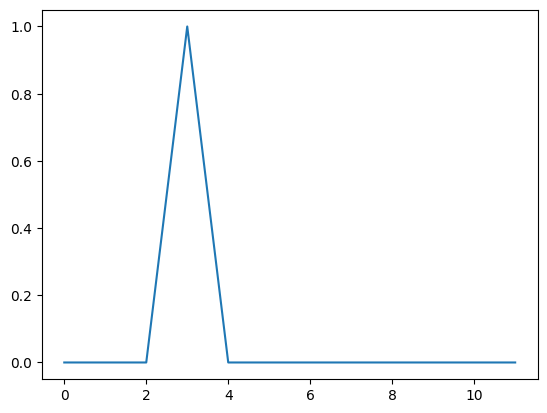

In [ ]:
# print(rewards)

# set title

plt.title("Rewards over episodes")
plt.xlabel("Episode")
plt.ylabel("Reward")

plt.plot(rewards)